<a href="https://colab.research.google.com/github/Ritanjit/SmartPhone_Price_Prediction_Model/blob/main/Mobile_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'mobile-price-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4654368%2F7920464%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240323%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240323T140249Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D74bbe85b4c0d6995022fcdcc90aa50af8ceebd391a2470283856a6dab200f36ff8223ff22e73e4aa20bbf66665fbcbb1ae915481a8d3ccbe4a966edba53714fe4aa20c124b51ea3e47160a060a74c78a03b23c4bbb09b318141bf81b0029c4eefa7a3907b1ddb2f199af1f4ae594477cca54300c275bf91ccb42464f923bd767054af593e27eec905a6f7c84d131772db039c153147e2e28a1f662858faa7fbdff34c5e08f19ea10c4b9b05857efdf68b5f47cd87d52f0c5824a9141d1ffee0a157b5f267c61f1f584d9debab85ae76e3278dfdd9d9fe0e874a48ab2bd1d06586829cc6a58b9bd63b9369d173e3d58a8b48b7db06c1df7db4888b334c9de81d6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 72340 bytes downloaded
Downloaded and uncompressed: mobile-price-classification
Data source import complete.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
df = pd.read_csv("/kaggle/input/mobile-price-classification/train.csv")
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [24]:
df.shape

(2000, 21)

In [25]:
df.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,...,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,...,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,...,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,...,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,...,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [27]:
df.isnull().sum() # This DataFrame has no null values.

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

# **# Heatmap of Mobile Price Classification**

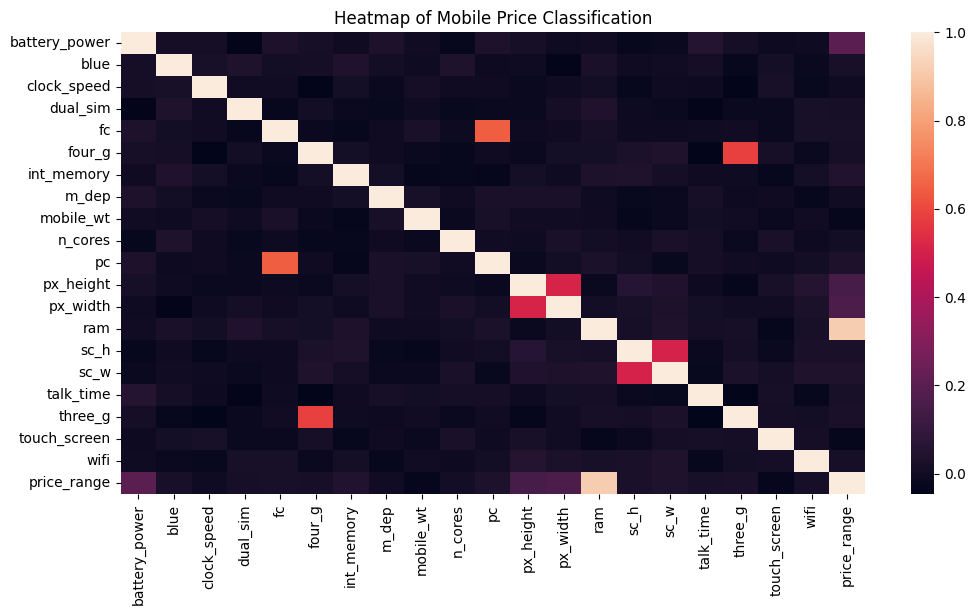

In [28]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr())
plt.title("Heatmap of Mobile Price Classification")
plt.show()
# Lighter boxes depict better relations and darker boxes depict bad relations

# **# Ploting Relation between Price Range and Battery Power**

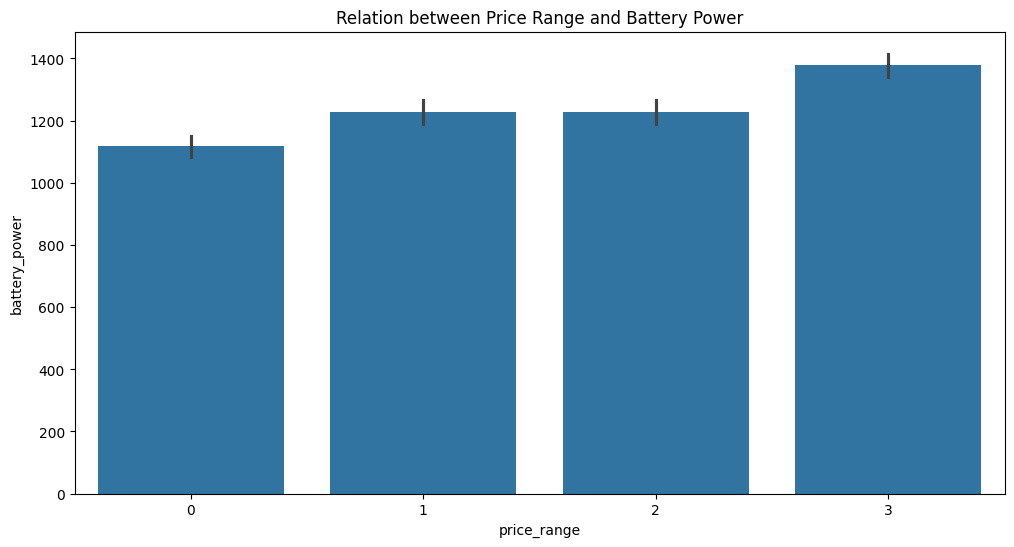

In [29]:
plt.figure(figsize=(12,6))
sns.barplot(x="price_range",y="battery_power",data=df)
plt.title("Relation between Price Range and Battery Power")
plt.show()
#The graph shows that mobile phones in price range 3, i.e, costing above 30000rs, have best battery power and for more price, battery power is increasing.

# **# Relation between price range and pixel Height/Width**

<ipython-input-30-c27e1b7186ac>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="price_range",y="px_height",data=df,palette="Reds")
<ipython-input-30-c27e1b7186ac>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = "price_range",y="px_width",data=df,palette="Blues")


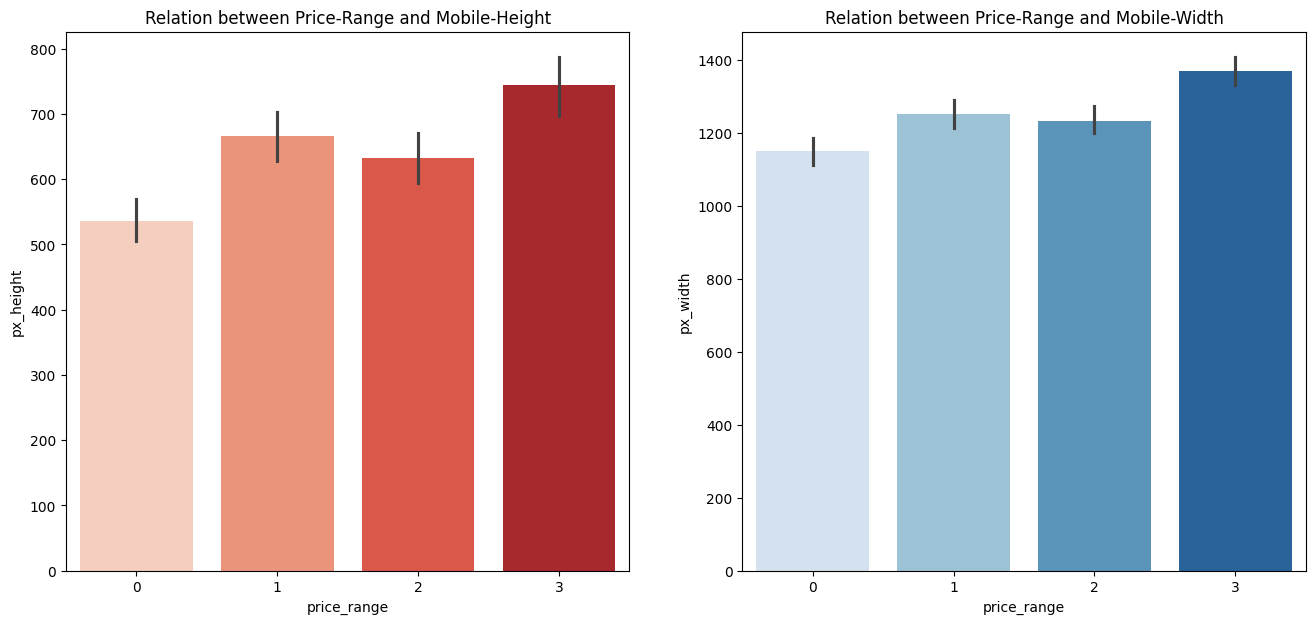

In [30]:
plt.figure(figsize = (16,7))
plt.subplot(1,2,1)
sns.barplot(x="price_range",y="px_height",data=df,palette="Reds")
plt.title("Relation between Price-Range and Mobile-Height")
plt.subplot(1,2,2)
sns.barplot(x = "price_range",y="px_width",data=df,palette="Blues")
plt.title("Relation between Price-Range and Mobile-Width")
plt.show()
# Mobile in higher price range of 3 has larger screen size. However, there can be seen that mobiles in price range 2 have smaller screen size than that of price range 1.

# **# Relation between Price-Range and RAM**

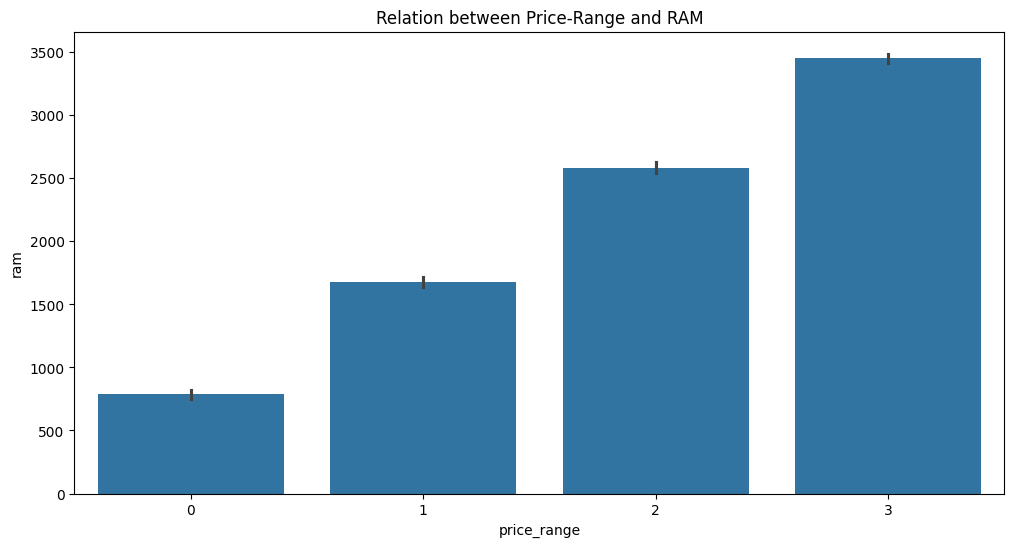

In [31]:
plt.figure(figsize=(12,6))
sns.barplot(x="price_range",y="ram",data=df)
plt.title("Relation between Price-Range and RAM")
plt.show()
# Mobile in higher price_range have higher ram and that in lowe price range have lower ram

# # Relation between Price-Range and Network-type (3g/4g)

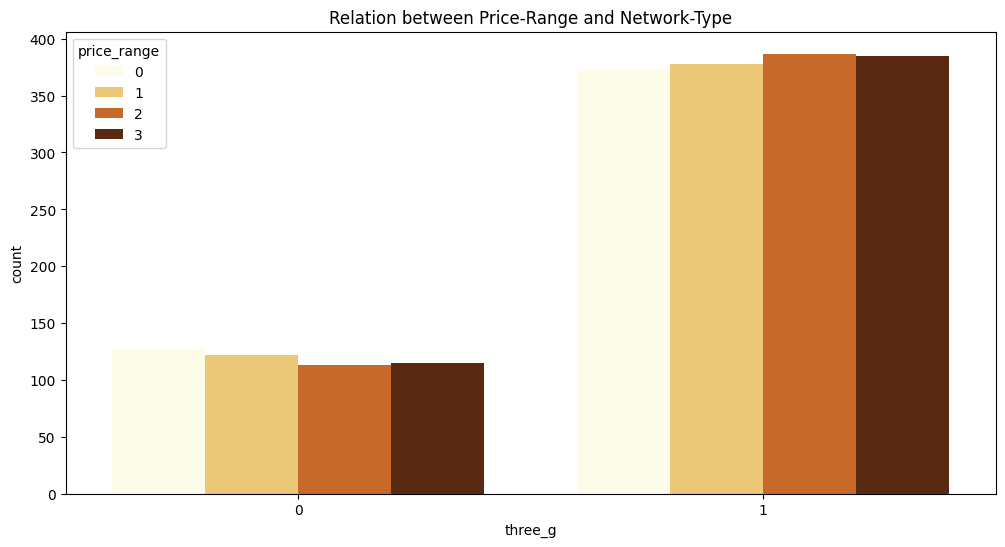

In [32]:
plt.figure(figsize=(12,6))
sns.countplot(x='three_g',data=df,hue=df['price_range'],palette='YlOrBr')
plt.title("Relation between Price-Range and Network-Type")
plt.show()
# The 1 in x direction shows the 3g phones and 0 shows non 3g phones.
# Price-range 3 has less 3g phones as those consist of more 4g phones.

# # Relation between Price-Range and Network-type (3g/4g)

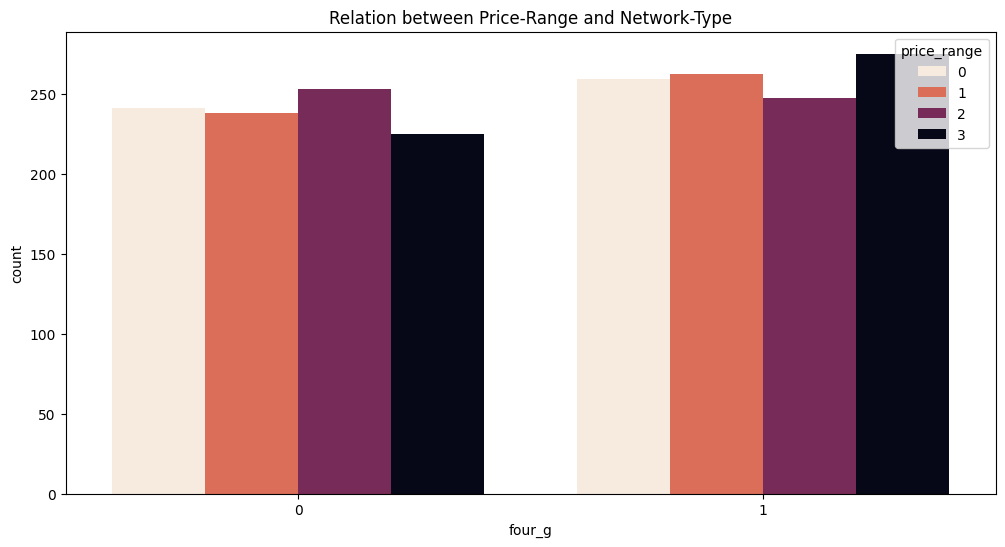

In [33]:
plt.figure(figsize=(12,6))
sns.countplot(x='four_g',data=df,hue=df['price_range'],palette='rocket_r')
plt.title("Relation between Price-Range and Network-Type")
plt.show()
# The 1 in x direction shows the 4g phones and 0 shows non 4g phones.
# The 4g mobiles are tallest bars as their price range is the highest

# Relation between Price-Range and Memory

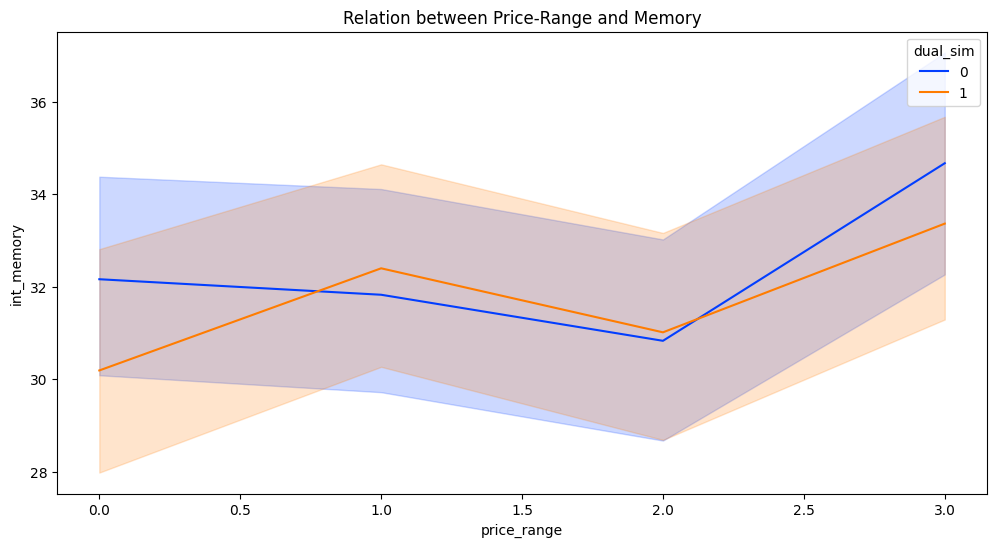

In [34]:
plt.figure(figsize=(12,6))
sns.lineplot(x='price_range',y='int_memory',data=df,hue='dual_sim',palette='bright')
plt.title('Relation between Price-Range and Memory')
plt.show()
# It is observed that phones with dual sim functionality have lower memory and those without dual sim have more memory.
# Also, phones without dual sim (with low memory) and phones with dual sim (with high memory) have almost equal price-range.

# # Data Preprocessing

In [35]:
x = df.drop(['price_range'],axis=1)
y = df['price_range']

In [55]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

# # KNN

In [37]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=10)

In [51]:
accuracy = knn.score(x_train,y_train)
print((accuracy*100).round())

95.0


In [39]:
predictions = knn.predict(x_test)

In [54]:
from sklearn.metrics import accuracy_score
final_accuracy = accuracy_score(y_test,predictions)
print(final_accuracy*100)

93.5


# # Predicting Values for Price-Range (test.csv)

In [41]:
test_df = pd.read_csv('/kaggle/input/mobile-price-classification/test.csv')
test_df.head()

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1043,1,1.8,1,14,0,5,0.1,193,...,16,226,1412,3476,12,7,2,0,1,0
1,2,841,1,0.5,1,4,1,61,0.8,191,...,12,746,857,3895,6,0,7,1,0,0
2,3,1807,1,2.8,0,1,0,27,0.9,186,...,4,1270,1366,2396,17,10,10,0,1,1
3,4,1546,0,0.5,1,18,1,25,0.5,96,...,20,295,1752,3893,10,0,7,1,1,0
4,5,1434,0,1.4,0,11,1,49,0.5,108,...,18,749,810,1773,15,8,7,1,0,1


In [42]:
test_df.shape # DataFrame has no price_range column but there is extra Id column. So, we need to remove it to make our model work on it.

(1000, 21)

In [43]:
test_df = test_df.drop(['id'],axis=1)
test_df.shape # removed the ID column to adjust it to the trained model.

(1000, 20)

In [44]:
test_pred = knn.predict(test_df)

In [45]:
test_df['predicted_price'] = test_pred # Adding the predicted price column in the DataFrame
test_df.shape

(1000, 21)

In [56]:
test_df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,predicted_price
0,1043,1,1.8,1,14,0,5,0.1,193,3,...,226,1412,3476,12,7,2,0,1,0,3
1,841,1,0.5,1,4,1,61,0.8,191,5,...,746,857,3895,6,0,7,1,0,0,3
2,1807,1,2.8,0,1,0,27,0.9,186,3,...,1270,1366,2396,17,10,10,0,1,1,2
3,1546,0,0.5,1,18,1,25,0.5,96,8,...,295,1752,3893,10,0,7,1,1,0,3
4,1434,0,1.4,0,11,1,49,0.5,108,6,...,749,810,1773,15,8,7,1,0,1,1
